# $\pi/4$ rotation in the $xy$ plane


In [10]:
%load_ext autoreload
%autoreload 2
import site
import sys
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *

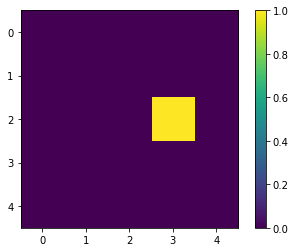

In [12]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
radius = 1/(2*nx)
centre = np.array([0.2,0,0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)
plt.imshow(v[:,:,2]); plt.colorbar()

angles = np.array([0,0,-np.pi/4])

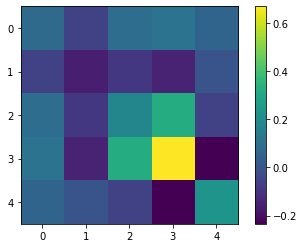

In [13]:
v_proj = project_spatial(v, angles, dimensions, "nn")

plt.imshow(v_proj); plt.colorbar()

In [14]:
point_idx = np.array(list(np.where(v == 1))).flatten()
point_idx

array([2, 3, 2])

### Step by step inside the project function

In [15]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
radius = 1/(2*nx)
centre = np.array([0.2,0,0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)
#plt.imshow(v[:,:,2]); plt.colorbar()

v = np.fft.ifftshift(v)

V, X, Y, Z, _, _, _ = volume_fourier(v, dimensions)

angles = np.array([0,0,-np.pi/4])



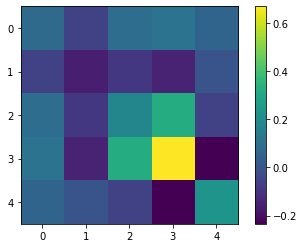

In [16]:
# Get x_grid, etc
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

# Rotate coordinates
slice_coords = rotate(x_grid, y_grid, angles)

# Interpolate and reshape
Vr0_flat = interpolate(slice_coords, x_grid, y_grid, z_grid, V, "nn")
Vr0 = Vr0_flat.reshape(5,5)

# Inverse Fourier transform
vr0 = np.real(np.fft.fftshift(np.fft.ifftn(Vr0)))


plt.imshow(vr0)
plt.colorbar()

In [17]:
# Compare with the above approach
np.sum(abs(vr0 - v_proj))

DeviceArray(6.9458328e-16, dtype=float64)

## Analytically

In [18]:
Ky = np.array([[0,0,0,0,0],[1,1,1,1,1],[2,2,2,2,2],[-2,-2,-2,-2,-2],[-1,-1,-1,-1,-1]], dtype=np.float64)
Kx = Ky.T

In [19]:
print(Kx)
print(Ky)

[[ 0.  1.  2. -2. -1.]
 [ 0.  1.  2. -2. -1.]
 [ 0.  1.  2. -2. -1.]
 [ 0.  1.  2. -2. -1.]
 [ 0.  1.  2. -2. -1.]]
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1.]]


In [20]:
# Construct Kxr and Kyr manually for np.pi/4 rotation and NN interpolation

Kxr =np.array([[0,1,1,-1,-1],
       [-1,0,1,-2,-1],
       [-1,-1,0,2,-2],
       [1,2,-2,0,1],
       [1,1,2,-1,0]])
     
Kyr = np.array([[0,1,1,-1,-1],
       [1,1,2,-1,0],
       [1,2,-2,0,1],
       [-1,-1,0,2,-2],
       [-1,0,1,-2,-1]])
    
    
print(Kxr)
print(Kyr)

[[ 0  1  1 -1 -1]
 [-1  0  1 -2 -1]
 [-1 -1  0  2 -2]
 [ 1  2 -2  0  1]
 [ 1  1  2 -1  0]]
[[ 0  1  1 -1 -1]
 [ 1  1  2 -1  0]
 [ 1  2 -2  0  1]
 [-1 -1  0  2 -2]
 [-1  0  1 -2 -1]]


In [21]:
# Find the indices (3,2) of the point mass after ifftshift (in the spatial domain)
xy_freq = np.array([0, 1, 2, -2, -1])
new_idx1 = np.fft.fftshift(xy_freq)[point_idx[0]]
new_idx2 = np.fft.fftshift(xy_freq)[point_idx[1]]

print(new_idx1)
print(new_idx2)

0
1


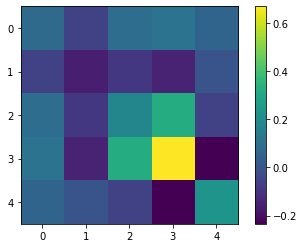

In [22]:
vr0_a = np.zeros([5,5], dtype = np.complex128)
for i in range(5):
    for j in range(5):
        vr0_a[i,j] = 1/25 * np.sum(
            np.exp(1j * 2 * np.pi/5* 
                # When ifftshifted, the indices (3, 2) become (1, 0)
                (i * Kx + j * Ky - new_idx1 * Kxr - new_idx2 * Kyr) 
            )
        )

vr0_a = np.real(np.fft.fftshift(vr0_a))
plt.imshow(vr0_a); plt.colorbar()

In [23]:
# Compare with the numerical result
np.max(abs(vr0_a - vr0))

1.1102230246251565e-16